In [1]:
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# In R, this can be computed using scales::pal_hue()(4)
hex_palette = ['#F8766D', '#7CAE00', '#00BFC4', '#C77CFF']
rgb_palette = [(248, 118, 109), (124, 174, 0), (0, 191, 196), (199, 124, 255)]

In [2]:
operator_map = {
    "phecode": "Phecode",
    "and": "and(x, y)",
    "not": "and(x, not(y))",
    "or": "or(x, y)",
}
operator_order = list(operator_map.values())
print(operator_order)

['Phecode', 'and(x, y)', 'and(x, not(y))', 'or(x, y)']


In [3]:
anon_df = (
    pl.scan_parquet("data/pheno_summary/direct_vs_indirect_anon.parquet")
    .join(pl.scan_parquet("data/gwas_summary/direct_vs_indirect_anon.parquet"), on=["kind", "phenotype", "k"], suffix="_gwas")
    .rename({"rsq": "rsq_pheno"})
    .with_columns(
        (
            pl.col("phenotype")
            .str.extract("^(and|or|not)")
            .fill_null("phecode")
            .replace({
                "phecode": "Phecode",
                "and": "and(x, y)",
                "not": "and(x, not(y))",
                "or": "or(x, y)",
            })
            .alias("operator")
        ),
        pl.col("k").cast(pl.Int32).cast(pl.String),
    )
    .collect()
)

non_anon_df = (
    pl.scan_parquet("data/pheno_summary/direct_vs_indirect_non_anon.parquet")
    .join(pl.scan_parquet("data/gwas_summary/direct_vs_indirect_non_anon.parquet"), on=["kind", "phenotype"], suffix="_gwas")
    .rename({"rsq": "rsq_pheno"})
    .with_columns(
        pl.col("phenotype")
        .str.extract("^(and|or|not)")
        .fill_null("phecode")
        .replace({
            "phecode": "Phecode",
            "and": "and(x, y)",
            "not": "and(x, not(y))",
            "or": "or(x, y)",
        })
        .alias("operator")
    )
    .collect()
)


# Find outlier phecodes

In [4]:
phecodes = (
    anon_df
    .filter(
        pl.col("k").eq("10"),
        pl.col("r_gwas").sub(pl.col("rsq_pheno")).ge(0.2),
    )
    ["phenotype"]
    .sort()
    .to_list()
)

phecodes

['250.1', '557']

In [5]:
phecodes = (
    non_anon_df
    .filter(
        pl.col("r_gwas").sub(pl.col("rsq_pheno")).ge(0.2),
    )
    ["phenotype"]
    .sort()
    .to_list()
)

phecodes

['250.1', '557']

# Recreate main plot

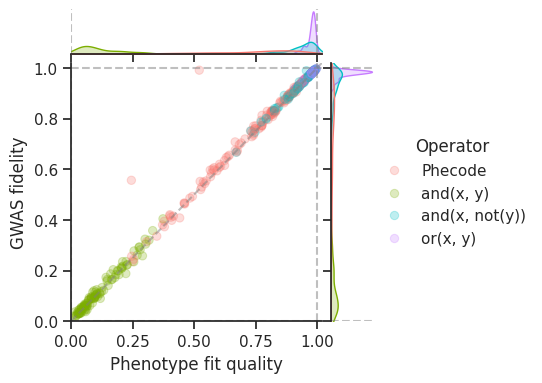

In [6]:
sns.set_style("ticks")
sns.set_context("notebook")
sns.set_palette(hex_palette)

# plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'sans-serif'
# plt.figure(figsize=(4, 4))

plot_df = (
    anon_df
    .filter(pl.col("k").eq("10"))
)

g = (
    plot_df
    .pipe(
        sns.jointplot, x="rsq_pheno", y="r_gwas", hue="operator", alpha=0.25, 
        xlim=(0.0, 1.02), ylim=(0.0, 1.02), 
        hue_order=operator_order, 
        height=4, edgecolors="face", linewidths=0.75, marginal_kws={'common_norm': False, "bw_adjust": 0.9}
    )
    .refline(x=0, y=0, linestyle="dashed", color="gray", alpha=0.5)
    .refline(x=1, y=1, linestyle="dashed", color="gray", alpha=0.5)
)
plt.axline((0, 0), slope=1, linestyle="dashed", color="gray", alpha=0.5)
plt.xlabel("Phenotype fit quality")
plt.ylabel("GWAS fidelity")
lgd = plt.legend(
    bbox_to_anchor=(1.17, 0.5), loc="center left", title="Operator", frameon=False
)

# Does the number of available cases explain this?

In [7]:
n_cases_df = (
    pl.scan_csv("data/pheno/approx_anon_phecodes_0010.tsv", separator="\t")
    .drop("#FID")
    .unpivot(index="IID", variable_name="phenotype", value_name="est")
    .join(
        pl.scan_csv("data/pheno/phecodes.tsv", separator="\t")
        .drop("#FID")
        .unpivot(index="IID", variable_name="phenotype", value_name="true"),
        on=["IID", "phenotype"],
    )
    .with_columns(pl.col("true", "est").sub(2))
    .group_by("phenotype")
    .agg(
        pl.col("est", "true").mean(),
        pl.len().alias("n"),
    )
    .collect()
)

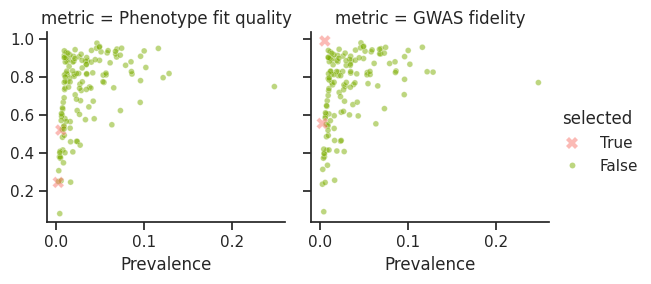

In [8]:
(
    anon_df
    .filter(pl.col("k").eq("10"))
    .join(n_cases_df, on=["phenotype"])
    .with_columns(selected=pl.col("phenotype").is_in(phecodes))
    .select("phenotype", "selected", "true", "rsq_pheno", "r_gwas")
    .unpivot(index=["phenotype", "selected", "true"], variable_name="metric")
    .with_columns(
        pl.col("metric").replace({"rsq_pheno": "Phenotype fit quality", "r_gwas": "GWAS fidelity"})
    )
    .pipe(
        sns.relplot, x="true", y="value", hue="selected", style="selected", col="metric", size="selected",
        hue_order=[True, False], size_order=[True, False], alpha=0.5, height=3
    )
    .set_axis_labels("Prevalence", "")
)

# Plot phenotype fits directly

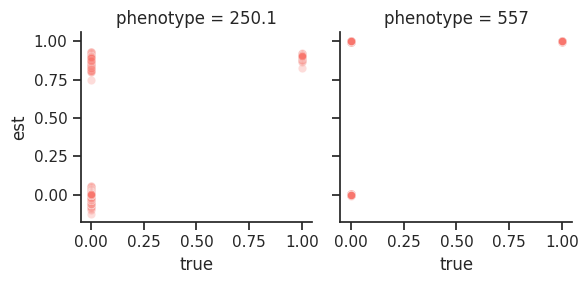

In [9]:
pheno_df = (
    pl.scan_csv("data/pheno/approx_anon_phecodes_0010.tsv", separator="\t")
    .select("IID", *phecodes)
    .unpivot(index="IID", variable_name="phenotype", value_name="est")
    .join(
        pl.scan_csv("data/pheno/phecodes.tsv", separator="\t")
        .select("IID", *phecodes)
        .unpivot(index="IID", variable_name="phenotype", value_name="true"),
        on=["IID", "phenotype"],
    )
    .with_columns(pl.col("true", "est").sub(2))
    .collect()
)

(
    pheno_df
    .pipe(sns.relplot, x="true", y="est", col="phenotype", alpha=0.25, height=3)
)

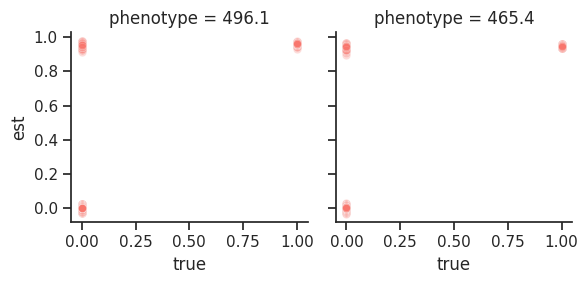

In [10]:
comparison = (
    n_cases_df
    .filter(~pl.col("phenotype").is_in(phecodes))
    .sort("true")
    .head(2)
    ["phenotype"]
    .to_list()
)

(
    pl.scan_csv("data/pheno/approx_anon_phecodes_0010.tsv", separator="\t", null_values=["NA"])
    .select("IID", *comparison)
    .unpivot(index="IID", variable_name="phenotype", value_name="est")
    .join(
        pl.scan_csv("data/pheno/phecodes.tsv", separator="\t", null_values=["NA"])
        .select("IID", *comparison)
        .unpivot(index="IID", variable_name="phenotype", value_name="true"),
        on=["IID", "phenotype"],
    )
    .with_columns(pl.col("true", "est").sub(2))
    .collect()
    .pipe(sns.relplot, x="true", y="est", col="phenotype", alpha=0.25, height=3)
)

<Axes: >

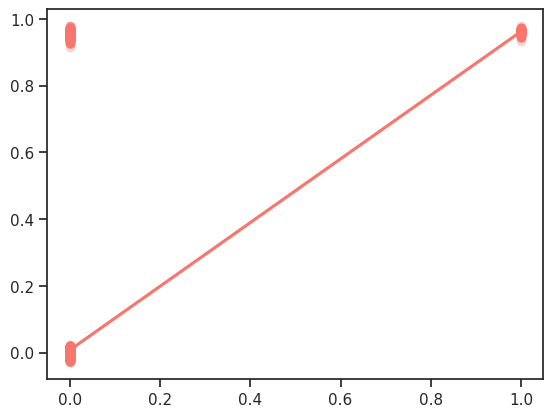

In [11]:
comparison = (
    n_cases_df
    .filter(~pl.col("phenotype").is_in(phecodes))
    .sort("true")
    .head(1)
    ["phenotype"]
    .to_list()
)

(
    pl.scan_csv("data/pheno/approx_anon_phecodes_0010.tsv", separator="\t", null_values=["NA"])
    .select("IID", *comparison)
    .unpivot(index="IID", variable_name="phenotype", value_name="est")
    .join(
        pl.scan_csv("data/pheno/phecodes.tsv", separator="\t", null_values=["NA"])
        .select("IID", *comparison)
        .unpivot(index="IID", variable_name="phenotype", value_name="true"),
        on=["IID", "phenotype"],
    )
    .with_columns(pl.col("true", "est").sub(2))
    .collect()
    .pipe(sns.regplot, x="true", y="est", scatter_kws=dict(alpha=0.25))
)

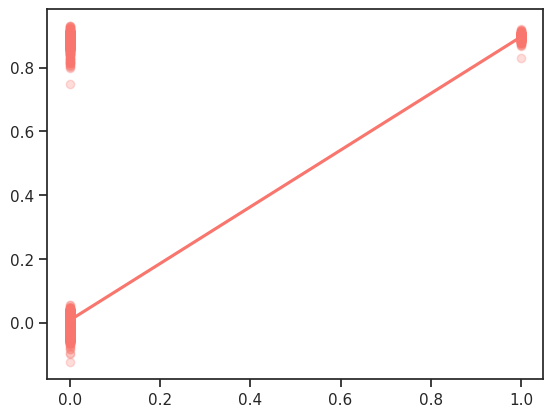

In [12]:
pheno_df = (
    pl.scan_csv("data/pheno/approx_anon_phecodes_0010.tsv", separator="\t")
    .select("IID", phecodes[0])
    .unpivot(index="IID", variable_name="phenotype", value_name="est")
    .join(
        pl.scan_csv("data/pheno/phecodes.tsv", separator="\t")
        .select("IID", phecodes[0])
        .unpivot(index="IID", variable_name="phenotype", value_name="true"),
        on=["IID", "phenotype"],
    )
    .with_columns(pl.col("true", "est").sub(2))
    .collect()
    .pipe(sns.regplot, x="true", y="est", scatter_kws=dict(alpha=0.25))
)

# Maximum GWAS chi-squared statistics by phenotype

In [13]:
max_df = (
    pl.scan_parquet("data/gwas_comparison/direct_vs_indirect_non_anon.parquet")
    .group_by("phenotype")
    .agg(
        max=pl.col("chisq_true").max(),
        var=pl.col("chisq_true").var(),
    )
    .filter(pl.col("phenotype").str.contains("^[0-9]"))
    .sort("max", descending=True)
    .collect()
)

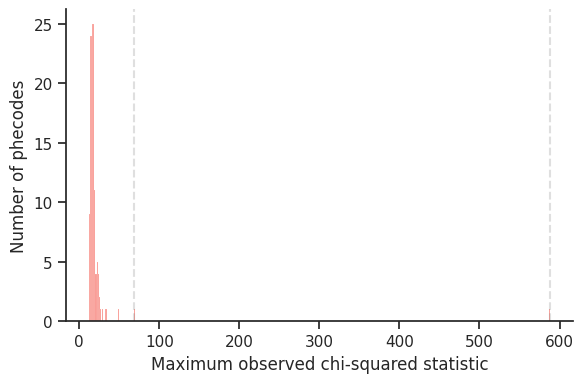

In [14]:
g = (
    max_df
    .pipe(sns.displot, x="max", height=4, aspect=1.5)
    .set_axis_labels("Maximum observed chi-squared statistic", "Number of phecodes")
)

for row in max_df.filter(pl.col("phenotype").is_in(phecodes)).to_dicts():
    g.refline(x=row["max"], color="gray", linestyle="dashed", alpha=0.25)

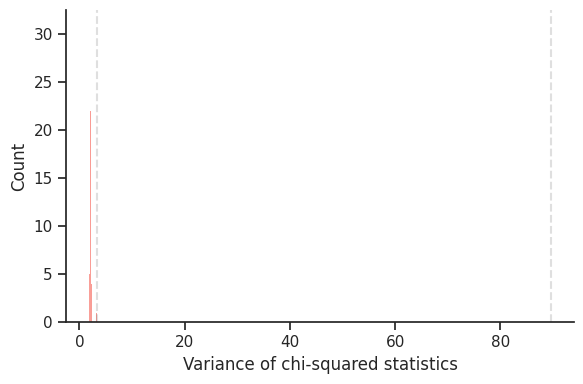

In [15]:
g = (
    max_df
    .pipe(sns.displot, x="var", height=4, aspect=1.5)
    .set_axis_labels("Variance of chi-squared statistics")
)

for row in max_df.filter(pl.col("phenotype").is_in(phecodes)).to_dicts():
    g.refline(x=row["var"], color="gray", linestyle="dashed", alpha=0.25)

In [16]:
comparison = (
    n_cases_df
    .filter(~pl.col("phenotype").is_in(phecodes))
    .sort("true")
    .head(5)
    ["phenotype"]
    .to_list()
)

gwas_df = (
    pl.scan_parquet("data/gwas_comparison/direct_vs_indirect_non_anon.parquet")
    .filter(pl.col("phenotype").is_in(phecodes + comparison))
    .with_columns(pl.col("phenotype").is_in(phecodes).alias("selected"))
    .collect()
)

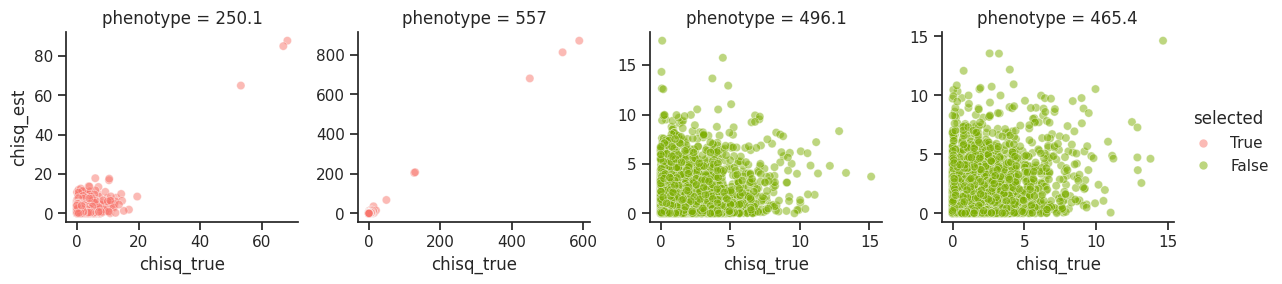

In [17]:
(
    gwas_df
    .filter(pl.col("phenotype").is_in(phecodes + comparison[:2]))
    .pipe(
        sns.relplot, x="chisq_true", y="chisq_est", col="phenotype", hue="selected", 
        hue_order=[True, False], alpha=0.5, facet_kws=dict(sharex=False, sharey=False),
        height=3
    )
)

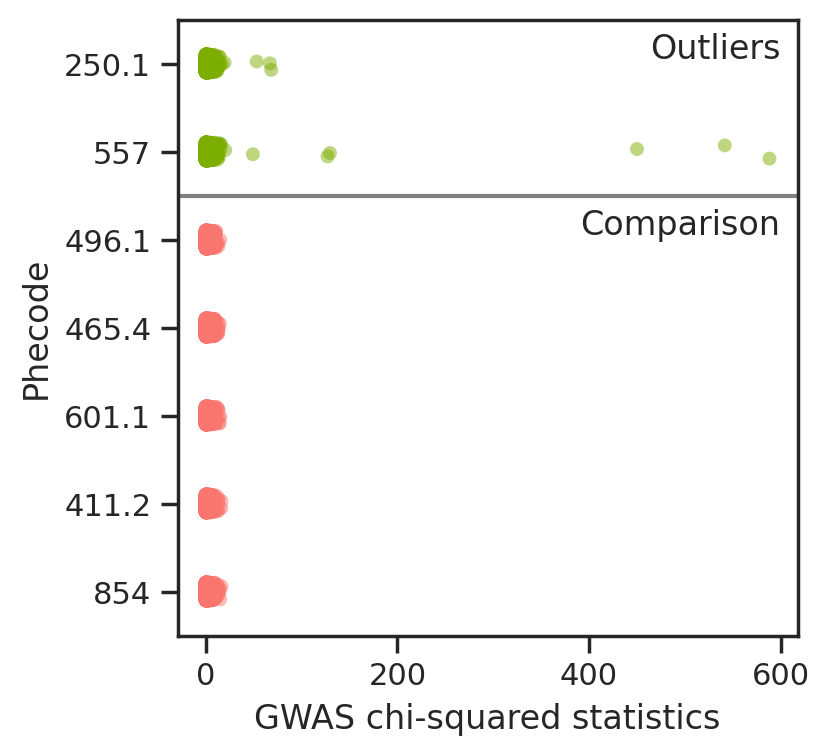

In [18]:
plt.rcParams['figure.dpi'] = 200
plt.figure(figsize=(4, 4))
(
    gwas_df
    .with_columns(
        pl.col("phenotype").cast(pl.Enum(phecodes + comparison))
    )
    .pipe(sns.stripplot, x="chisq_true", y="phenotype", hue="selected", alpha=0.5)
)
plt.axhline(y=1.5, color="gray")
plt.text(x=600, horizontalalignment="right", y=-0.35, verticalalignment="top", s="Outliers")
plt.text(x=600, horizontalalignment="right", y=1.65, verticalalignment="top", s="Comparison")
plt.legend([],[], frameon=False)
plt.xlabel("GWAS chi-squared statistics")
plt.ylabel("Phecode")
plt.savefig(
    "img/outliers.png", dpi=400, format="png", bbox_inches='tight'
)